<br><br><br><br>
<center><img src='FAV_logo_jvs.jpg'></center>
<br><br><br><br>
<br><br><br><br>

# <center>Dolní odhad prvního vlastního čísla p-laplaciánu </center>

<center><b>KMA/OSMA</b></center>
<center><b>Honza Půlpán</b></center>
<br><br><br><br><br><br><br><br><br><br><br><br>

## Teoretický úvod

Cílem je získat dolní odhad prvního vlastního čísla úlohy 

\begin{equation}
\left\{ \begin{array}{rll}
-\Delta_p u(t) &= \ \lambda |u(t)|^{p-2}u(t), \quad t\in(0, 1), \\
u(0)&= \ u(1) \ = \  0, \\
\end{array}
\right.
\label{eq:plaplace} \tag{1}
\end{equation}


kde $\Delta_p u := \left(|u'|^{p-2}u' \right)'$ je tzv. p-laplacián.

Přesná hodnota prvního vlastního čísla $\lambda_1$ je známa a v závislosti na $p$ ji lze vyjádřit jako

\begin{equation}
\lambda_1 = (p-1)\left( \frac{2\pi}{p\sin{\frac{\pi}{p}}} \right)^p,
\label{l1_exact} \tag{2}
\end{equation}

první vlastní funkce má následující tvar

\begin{equation}
e_p =(p-1)^{-\frac{1}{p}} \sin_p{\left( \pi_px \right)}.
\label{e1_exact} \tag{3}
\end{equation}

Dolní odhad prvního vlastního čísla lze vyjádřit pomocí piconeho identity následujícím způsobem

\begin{equation}
\lambda_1 \geq \inf_{v} \frac{-\Delta_p v}{v^{p-1}} 
\label{l1_lower_bound} \tag{4}
\end{equation}

kde $v$ je testovací funkce. Rovnost platí, pokud se $v$ rovná první vlastní funkci $e_p$.

## Algoritmus získání dolního odhadu $\lambda_1$

Dolní odhad prvního vlastního čísla úlohy ([1](#mjx-eqn-eq:plaplace)) získáme pomocí intervalové aritmetiky následujícím postupem:

1. získáme numerické řešení úlohy převedené na soustavu - $u_1$, $u_2$ - všechny následující výpočty jsou již intervalové
2. proložíme $u_2$ kubickým splinem
3. získáme $u_1$ ze splinu proloženého $u_2$
4. intervalově výpočteme derivaci $u_2$
5. dosadíme do podílu pro získání odhadu $\lambda_1$

Algoritmus probereme podrobně a připravíme si i potřebný kód v Julia.


In [19]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
using DataInterpolations
using LinearAlgebra
using ForwardDiff

### Numerické řešení

Pomocí substituce $u_1 = u$, $u_2 = |u'|^{p-2}u'$ převedeme úlohu ([1](#mjx-eqn-eq:plaplace)) na soustavu

\begin{equation}
\left\{ \begin{array}{rll}
u_1'(t) &= |u_2(t)|^{\frac{1}{p-1}} \;\text{sgn}(u_2(t)),\\
u_2'(t) &= -\lambda \;|u_1(t)|^{p-1} \;\text{sgn}(u_1(t)),\\
u_1(0) &= 0, \\
u_2(0) &= 1. \\
\end{array}
\right.
\label{eq:plaplace-set} \tag{5}
\end{equation}

Tu pak následně řešíme metodou střelby. Řešením jsou funkce $u_1$ odpovídající řešení $u$ původní úlohy a tedy i první vlastní funkci a $u_2 = |u'|^{p-2}u'$ odpovídající výrazu v závorce v p-laplacianu.


In [20]:
"""
Vypočítá numerické řešení p-laplaciánu.

Vstupní parametry:
λi ... interval na kterém hledám λ₁
P ... p z p-laplaciánu
n ... počet kroků dělení

Return:
t, u1, u2, u2i
"""
function plaplace_solve(λi, P, n; plt_res=true)
   
    function sl(du,u,p,t) # parametr p je odhad na λ₁ a p z p-laplacianu
        λ, pl = p
        du[1] = abs(u[2])^(1/(pl-1)) * sign(u[2])
        du[2] = -λ * abs(u[1])^(pl-1)*sign(u[1]) 
    end

    u0 = [0.0; 1.0;] # počáteční podmínka
    a, b = λi
    s = (a + b)/2
    Δt = 1.0/(n-1) # velikost intervalu dělení
    e = 1e-12 # zastavovací podmínka

    while (b-a) >= e
        prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
        sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)
        if sol(1)[1] == 0 # hodnota u₁ v t=1
            break
        else
            probA = ODEProblem(sl, u0, (0.0, 1.0), (a, P))
            solA = solve(probA, saveat=Δt, abstol=1e-8,reltol=1e-8)
            probS = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
            solS = solve(probS, saveat=Δt, abstol=1e-8,reltol=1e-8)
            if solA(1)[1] * solS(1)[1] < 0
                b = s
            else
                a = s
            end
            s = (a+b)/2
        end
    end

    prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
    sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)

    if plt_res
        println("Numericky získané první vlastní číslo λ₁: $s")
        display(plot(sol,marker=2))
    end
    
    t = sol.t
    ti = [@interval(i) for i in t]
    u1 = [u[1] for u in sol.u]
    u1i = [@interval(u[1]) for u in sol.u]
    u2 = [u[2] for u in sol.u]
    u2i = [@interval(u[2]) for u in sol.u]
    
    return t, ti, u1, u2, u2i, s
end;

### Proložení $u_2$ kubickým splinem

Použijeme standardní metodu abychom proložili řešení $u_2$ kubickým spinem. Výpočet provádíme intervalově. Jedinou složitější věcí je jak stanovit hodnoty druhých derivací v krajních bodech. ....

PODLE ROVNIC BY TO MĚLO BÝT NĚJAK, ALE OPTIMÁLNÍ HODNOTA JE JINDE, JAK SI UKÁŽEME PŘI NUMERICKÝCH EXPERIMENTECH

OPTIMÁLNÍ HODNOTY PRO:
- p=3/2: vlevo= -9.988, vpravo= +10.131
- p=3: vlevo= +0.01065 , vpravo=-0.03425

In [3]:
# proložení u2 splinem

# vrací koeficienty a možná i napočítané hodnoty(???) - potřebuju je? (ano, potřebuju při výpočtu u1 jsou používány)
# kresí řešení i s řešením numerickým

function cubic_spline(t, ti, u, ui, d2ul, d2ur; plt_res=true, pn=10)
    #matice A
    n=length(ui)
    dv = [4..4 for i in 1:n-2]
    ev = [1..1 for i in 1:n-3]
    A = Array(SymTridiagonal(dv,ev))
    A_inv = inv(A) #inverze

    #pravá strana
    h = 1.0/(n-1)
    # sestavení pravé strany
    rhs = []
    for i in 3:length(ui)
        append!(rhs, 6/h^2 * (ui[i] - 2 * ui[i-1] + ui[i-2]))
    end

    # vypočte vektor druhých derivací potřebný na výpočet koeficientů
    ######### NASTAVOVAT SPRÁVNĚ DRUHOU DERIVACI NA KRAJÍCH
    
    d2u = []
    #append!(d2v, @interval(10*(P-1)*α*s)) # druhou derivaci nastavíme na přihbližnou hodnotu λ₁
    append!(d2u, @interval(d2ul)) # druhou derivaci nastavíme na přihbližnou hodnotu λ₁
    append!(d2u, A_inv*rhs)
    append!(d2u, @interval(d2ur))#-1));

    # výpočet koeficientů jednotlivých oblouků splinu
    csc_u = [] #@interval zeros(4, length(solu)-1)
    for i in 1:length(ui)-1
        a=b=c=d=0
        a = (d2u[i+1]-d2u[i])/(6*h)
        b = d2u[i]/2 
        c = (ui[i+1] - ui[i])/h - h*(2*d2u[i]+d2u[i+1])/6
        d = ui[i]
        append!(csc_u, [[a,b,c,d]])
    end 
    

    if plt_res
        p = plot(t, u, marker=2)
    end
    usi = Interval[] # intervalové vyjádření splinu na pi
    for i in 1:length(ui)-1
        x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
        x_int = mince(x_dom,pn)
        f(x) = csc_u[i][1]*(x-ti[i])^3 + csc_u[i][2]*(x-ti[i])^2 + csc_u[i][3]*(x-ti[i]) + csc_u[i][4]
        append!(usi, f.(x_int))
        if plt_res
            boxes = IntervalBox.(x_int, f.(x_int))    
            plot!(boxes, legend=false)
        end
    end
    if plt_res display(p) end
        
    return csc_u, usi
end;

### Intervalové vyjádření $u_1$

Dalším krokem je získání $u_1$, které intervalově vypočteme z $u_2$. Výslednou funkci posunume o pevnou konstantu $\delta = \min_{t \in (0,1)}u_1$. Pro případ $\delta <= 0$ (k jinému nemůže dojít), přičteme k $u_1$ konstantu o něco větší než $\delta$.  Celý výpočet je opět intervalový.

In [4]:
#napočítání u1

# paramaterem jsou hodnoty u2, časové intervaly tints a posunutí δ
# vrací intervalové vyjádření u1
# vykresluje funkci i s numerickým řešením u

function get_u1(P, u2spl, t, u1; plt_res=true)
    
    f(x) = abs(x)^(1/(P-1))*sign(x)
    ni = mince(0..1,length(u2spl))

    u1tmp = Interval[0..0]
    for i in 1:length(u2spl)
        append!(u1tmp, u1tmp[end] + f(u2spl[i]) * diam(ni[i]))
    end

    u1si = Interval[]
    for i in 1:length(u1tmp)-1
        append!(u1si, u1tmp[i] ∪ u1tmp[i+1])
    end

    δ = inf(minimum(u1si))
    if δ > 0
        u1si = u1si .- (δ - δ*1e-8)
    else
        u1si = u1si .+ (-δ - δ*1e-8)
    end

    if plt_res
        x_int = mince(0..1,length(u2spl))
        boxes = IntervalBox.(x_int, u1si)
        plot(boxes)
        display(plot!(t, u1, marker=2))
    end
    
    return u1si
    
end;

### Derivace $u_2$

Pro výpočet dolního odhadu $\lambda_1$ potřebujeme vyjádřit $\Delta_p u = u_2'$. Derivaci $u_2$ získáme snadno intervalově, stačí použít koeficienty proloženého kubického splinu.

In [5]:
# derivace u2

function der_cubic_spline(csc, t, ti, pn; plt_res = true)
    
    u = Interval[]
    csc_uder = [ [@interval(3) * c[1], @interval(2) * c[2], c[3]] for c in csc ] 
    for i in 1:length(t)-1
        x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
        x_int = mince(x_dom,pn)
        f(x) = csc_uder[i][1]*(x-ti[i])^2 + csc_uder[i][2]*(x-ti[i]) + csc_uder[i][3]
        append!(u, f.(x_int))
    end
    
    if plt_res
        x_int = mince(0..1,length(u))
        display(plot(IntervalBox.(x_int, u)))
    end
    
    return u
end;

# Výpočet dolního odhadu $\lambda_1$

Nyní již stačí dosadit získané funkce do výrazu $$ \lambda_1 \geq \inf_{v} \frac{-\Delta_p v}{v^{p-1}}. $$

In [6]:
function lower_bound(numer, denom; plt_res=true)
    f(x,y) = -x / y^(P-1)
    lb_tmp = f.(numer, denom)

    low_bound = Interval[100..100]
    for i in 1:length(lb_tmp)-1
        append!(low_bound, lb_tmp[i] ∪ lb_tmp[i+1])
    end
    
    l1 = inf(minimum(low_bound))
    println("Dolní odhad λ₁: $l1")
    
    if plt_res
        boxes = IntervalBox.(mince(0..1, length(low_bound)), low_bound)
        display(plot(boxes, ylim=(l1/2,3*l1/2)))
    end
    
    return l1, low_bound
end


lower_bound (generic function with 1 method)

## Numerické experimenty

Algoritmus dolního odhadu ověříme na několika konkrétních úlohách pro různá $p$. 

### p=3/2

Nejprve nastavíme základní parametry a získáme numerické řešení včetně numerické hodnoty $\lambda_1$.
- JAK DŮLEŽITÉ JE DĚLENÍ ŘEŠENÍ n A JAK DĚLENÍ OBLOUKŮ SPLINU pn.

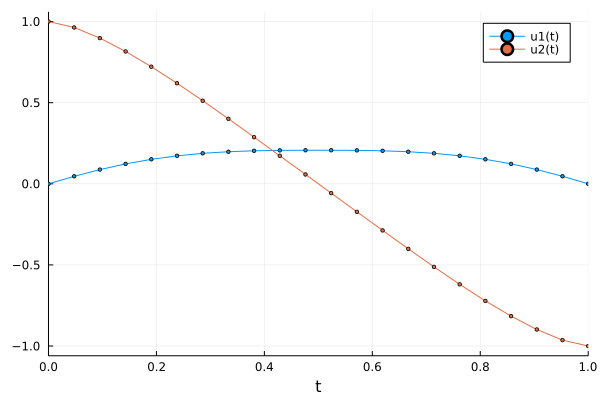

Numericky získané první vlastní číslo λ₁: 5.318718074184005


In [7]:
# nastavení parametrů
P=1.5
λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P

n = 22 # kroků dělení
pn = 10000 # dělení jednotlivého oblouku spline
pi = mince(0..1,(n-1)*pn) # dělení výsedného splinu

δ = 5.65723e-05 #0.01-0.009-0.0009; # posunutí fce

λinit = (3.,8.); # interval na kterém hledá λ₁ (nesmí obsahovat i λ₂, jinak to můž najít to)

t, ti, u1, u2, u2i, l1 = plaplace_solve(λinit, P, n);

Následně sestavíme kubický spline pro $u_2$. Potřebné druhé derivace v krajních bodech $u_2''(0)$ a $u_2''(1)$ získáme ...

In [8]:
# p=3/2: vlevo= -9.988, vpravo= +10.131
#csc_u2, u2si = cubic_spline(t, ti, u2, u2i, -(P-1)*δ*l1, (P-1)*δ*l1, pn=pn);
csc_u2, u2si = cubic_spline(t, ti, u2, u2i, -9.988, 10.131, pn=pn, plt_res=false);

Nyní z $u_2$ sestavíme intervalově $u_1$ a přičteme takové $\delta$, aby platilo $u_1(t) > 0$ pro všechna $t \in [0,1]$.

In [9]:
u1si = get_u1(P,u2si, t, u1, plt_res=false);

Vyjádříme derivaci $u_2$ a získáme tak $\Delta_p u$.

In [10]:
u2si_der = der_cubic_spline(csc_u2, t, ti, pn, plt_res=false);

Posledním krokem je dosazení do vztahu pro dolní odhad. 

In [11]:
λlb, lb_func = lower_bound(u2si_der, u1si, plt_res=false);

Dolní odhad λ₁: 4.8913060311108705


In [12]:
λ1-λlb

0.4274120452682988

### $p=3$

Nejprve opět nastavíme základní parametry a vypočteme numerické řešení. Další kroky pak provedeme bez vykreslování jednotlivých grafů.

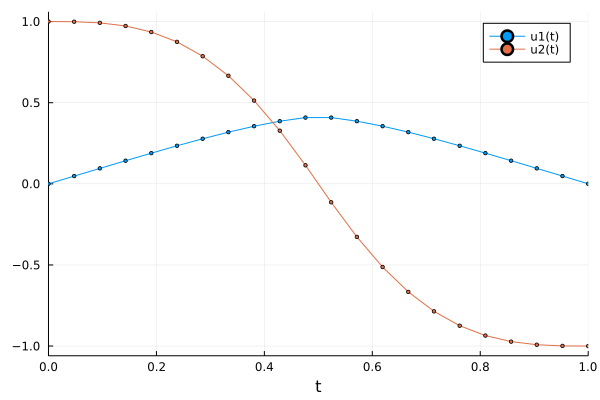

Numericky získané první vlastní číslo λ₁: 28.28876197305467
Dolní odhad λ₁: 28.07553191509198


In [13]:
# nastavení parametrů
P=3
λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P

n = 22 # kroků dělení
pn = 10000#2 # dělení jednotlivého oblouku spline
pi = mince(0..1,(n-1)*pn) # dělení výsledného splinu

δ = 5.52229e-05#0.01-0.009-0.0009; # posunutí fce

λinit = (3.,40.); # interval na kterém hledá λ₁ (nesmí obsahovat i λ₂, jinak to můž najít to)

t, ti, u1, u2, u2i, l1 = plaplace_solve(λinit, P, n);

#p=3: vlevo= +0.01065 , vpravo=-0.03425
csc_u2, u2si = cubic_spline(t, ti, u2, u2i, 0.01065, -0.034251, pn=pn, plt_res=false);
#csc_u2, u2si = cubic_spline(t, ti, u2, u2i, -(P-1)*δ*l1, (P-1)*δ*l1, pn=pn, plt_res=false);
u1si = get_u1(P,u2si, t, u1, plt_res=false);
u2si_der = der_cubic_spline(csc_u2, t, ti, pn, plt_res=false);
λlb, lb_func = lower_bound(u2si_der, u1si, plt_res=false);

In [14]:
λ1-λlb

0.21323006091057195

20
Dolní odhad λ₁: 4.891325363290679
21
Dolní odhad λ₁: 4.89160253480592
22
Dolní odhad λ₁: 4.8916082100169485
23
Dolní odhad λ₁: 4.886436994236562
24
Dolní odhad λ₁: 4.881528536504317
25
Dolní odhad λ₁: 4.8768640872509526


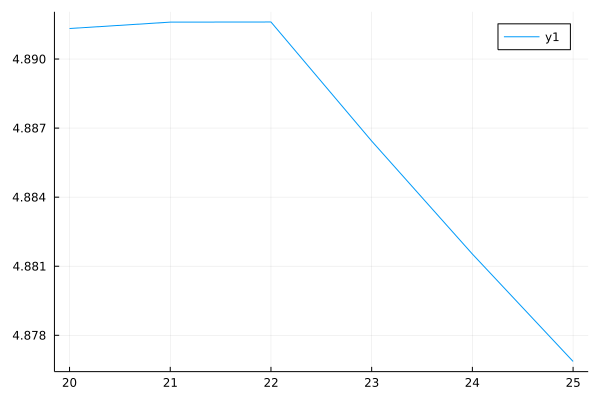

In [15]:
P=3/2
λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P

n = 22 # kroků dělení
pn = 15000 # dělení jednotlivého oblouku spline
pi = mince(0..1,(n-1)*pn) # dělení výsledného splinu

#δ = 5.52229e-05#0.01-0.009-0.0009; # posunutí fce

λinit = (3.,10.); # interval na kterém hledá λ₁ (nesmí obsahovat i λ₂, jinak to můž najít to)



#pns = [2000,2500,3500,5000,10000, 10001, ]
ns = 20:25
l1seq = []
for n in ns
    println(n)

    t, ti, u1, u2, u2i, l1 = plaplace_solve(λinit, P, n, plt_res=false);
    #p=3: vlevo= +0.01065 , vpravo=-0.03425
    csc_u2, u2si = cubic_spline(t, ti, u2, u2i, -9.988, 10.131, pn=pn, plt_res=false);
    
    u1si = get_u1(P,u2si, t, u1, plt_res=false);
    u2si_der = der_cubic_spline(csc_u2, t, ti, pn, plt_res=false);
    λlb, lb_func = lower_bound(u2si_der, u1si, plt_res=false);
    append!(l1seq, λlb)
end
plot(ns,l1seq)
